In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from datetime import datetime

import argparse
import os

import fsspec
import numpy as np
import pandas as pd
import xarray as xr
import goes2go
import pandas as pd
from tqdm import tqdm

from pyproj import Proj
from scipy.interpolate import make_splrep

In [2]:
ibtracs_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.ALL.list.v04r01.csv'
ibtracs_na_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.NA.list.v04r01.csv'
ibtracs_ep_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.EP.list.v04r01.csv'
ibtracs_wp_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.WP.list.v04r01.csv'
ibtracs_sp_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.SP.list.v04r01.csv'
ibtracs_si_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.SI.list.v04r01.csv'
ibtracs_sa_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.SA.list.v04r01.csv'
ibtracs_ni_file = '/home/users/annaju/eo-data-prep/notebooks/IBTrACs/ibtracs.NI.list.v04r01.csv'

In [3]:
df = pd.read_csv(ibtracs_file)
df_na = pd.read_csv(ibtracs_na_file)
df_ep = pd.read_csv(ibtracs_ep_file)
df_wp = pd.read_csv(ibtracs_wp_file)
df_sp = pd.read_csv(ibtracs_sp_file)
df_si = pd.read_csv(ibtracs_si_file)
df_sa = pd.read_csv(ibtracs_sa_file)
df_ni = pd.read_csv(ibtracs_ni_file)

/tmp/ipykernel_45541/3797323616.py:1: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ibtracs_file)
/tmp/ipykernel_45541/3797323616.py:2: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_na = pd.read_csv(ibtracs_na_file)
/tmp/ipykernel_45541/3797323616.py:3: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ep = pd.read_csv(ibtracs_ep_file)
/tmp/ipykernel_45541/3797323616.py:4: DtypeWarning: Columns (1,2,8,9,14,142,143,144,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wp = pd.read_csv(ibtracs_wp_file)
/tmp/ipykernel_45541/3797323616.py:5: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv(ibtracs_sp_file)
/tmp/ipyke

### Western Pacific Files

In [4]:
df_wp_filtered = df_wp[df_wp.SEASON.isin([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])]
df_wp_filtered = df_wp_filtered[df_wp_filtered.NATURE.isin(['TS', 'DS'])]
df_wp_filtered = df_wp_filtered[df_wp_filtered.NAME != 'UNNAMED']
# filter for GOES FOV
df_wp_filtered = df_wp_filtered[df_wp_filtered.LAT.between(-50, 50) & df_wp_filtered.LON.between(91, 191)]

# filter out storms with less than 8 points
grouped = df_wp_filtered.groupby('SID')
lengths = grouped.size()
df_wp_filtered = df_wp_filtered[df_wp_filtered.SID.isin(lengths[lengths >= 8].index)]

In [32]:
len(df_wp_filtered.SID.unique())

207

In [33]:
df_wp_filtered.LAT.min(), df_wp_filtered.LAT.max(), df_wp_filtered.LON.min(), df_wp_filtered.LON.max()

(2.8, 45.9, 91.1, 191.0)

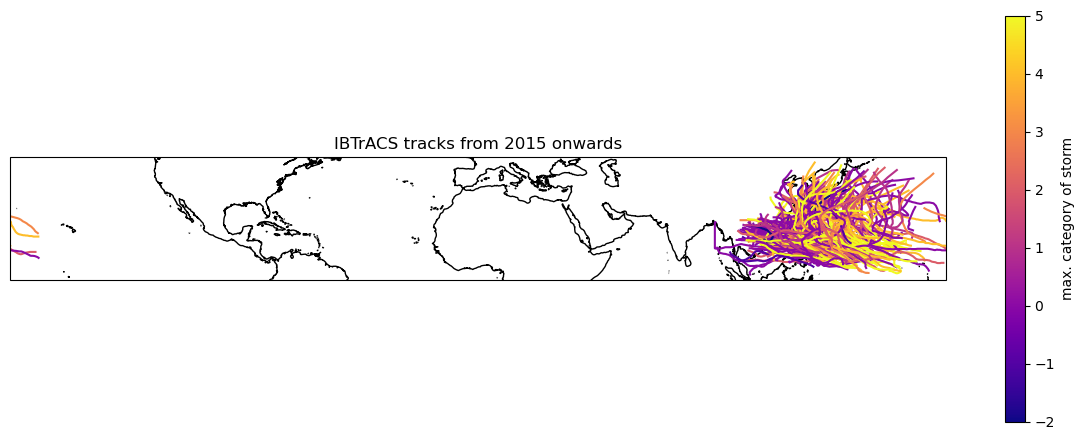

In [10]:
# Plot tracks on map
fig, ax = plt.subplots(figsize=(12, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
grouped = df_wp_filtered.groupby('SID')

# plot every track with colour for category
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=-2, vmax=5)
for i, (name, group) in enumerate(grouped):
    max_cat = group['USA_SSHS'].max()
    ax.plot(group['LON'], group['LAT'], transform=ccrs.PlateCarree(), label=name, color=cmap(norm(max_cat)))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with colorbar
plt.colorbar(sm, ax=ax, label='max. category of storm')
plt.title('IBTrACS tracks from 2015 onwards')

plt.tight_layout()

### Southern Pacific

In [5]:
df_sp_filtered = df_sp[df_sp.SEASON.isin([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])]
df_sp_filtered = df_sp_filtered[df_sp_filtered.NATURE.isin(['TS', 'DS'])]
df_sp_filtered = df_sp_filtered[df_sp_filtered.NAME != 'UNNAMED']
# filter for GOES FOV
df_sp_filtered = df_sp_filtered[df_sp_filtered.LAT.between(-50, 50) & df_sp_filtered.LON.between(91, 191)]

# filter out storms with less than 8 points
grouped = df_sp_filtered.groupby('SID')
lengths = grouped.size()
df_sp_filtered = df_sp_filtered[df_sp_filtered.SID.isin(lengths[lengths >= 8].index)]

In [35]:
len(df_sp_filtered.SID.unique())

57

In [36]:
df_sp_filtered.LAT.min(), df_sp_filtered.LAT.max(), df_sp_filtered.LON.min(), df_sp_filtered.LON.max()

(-32.8, -3.7, 95.9, 191.0)

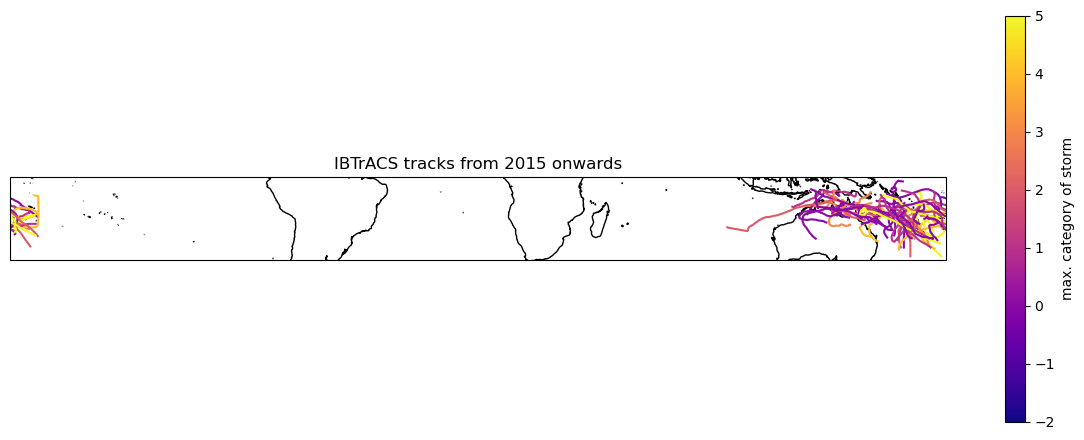

In [17]:
# Plot tracks on map
fig, ax = plt.subplots(figsize=(12, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
grouped = df_sp_filtered.groupby('SID')

# plot every track with colour for category
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=-2, vmax=5)
for i, (name, group) in enumerate(grouped):
    max_cat = group['USA_SSHS'].max()
    ax.plot(group['LON'], group['LAT'], transform=ccrs.PlateCarree(), label=name, color=cmap(norm(max_cat)))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with colorbar
plt.colorbar(sm, ax=ax, label='max. category of storm')
plt.title('IBTrACS tracks from 2015 onwards')

plt.tight_layout()

In [6]:
# merge into one dataframe
df_all = pd.concat([df_wp_filtered, df_sp_filtered], ignore_index=True)
df_all

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 06:00:00,DS,8.6,145.9,...,,,,,,,,,12,275
1,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 09:00:00,DS,8.6,145.3,...,,,,,,,,,12,275
2,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 12:00:00,DS,8.7,144.7,...,,,,,,,,,12,275
3,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 15:00:00,DS,8.8,144.1,...,,,,,,,,,11,275
4,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 18:00:00,DS,8.8,143.6,...,,,,,,,,,9,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,2022137S13171,2022,33,SP,MM,GINA,2022-05-20 15:00:00,TS,-19.4,168.2,...,,,,,,,,,8,135
14488,2022137S13171,2022,33,SP,MM,GINA,2022-05-20 18:00:00,TS,-19.7,168.5,...,,,,,,,,,9,120
14489,2022137S13171,2022,33,SP,MM,GINA,2022-05-20 21:00:00,TS,-19.9,168.9,...,,,,,,,,,9,115
14490,2022137S13171,2022,33,SP,MM,GINA,2022-05-21 00:00:00,TS,-20.1,169.4,...,,,,,,,,,8,120


In [7]:
# filter out all storms that started before 2015-07-07 or after 2022-12-12
df_all['ISO_TIME'] = pd.to_datetime(df_all['ISO_TIME'], format='%Y-%m-%d %H:%M:%S')
df_all['ISO_DATE'] = df_all['ISO_TIME'].dt.date
df_all = df_all[(df_all['ISO_DATE'] >= datetime(2015, 7, 7).date()) & (df_all['ISO_DATE'] <= datetime(2022, 12, 12).date())]

In [67]:
df_all.to_csv('himawari_ibtracs.SP-WP.list.v04r01.csv', index=False)

In [8]:
# convert ISO_TIME to datetime
df_all['ISO_TIME'] = pd.to_datetime(df_all['ISO_TIME'])

/tmp/ipykernel_45541/1531927925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['ISO_TIME'] = pd.to_datetime(df_all['ISO_TIME'])


In [9]:
# find total number of days covered by all storms
total_days = df_all.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()

print(f"Total number of days covered by all storms: {total_days}")
print(f"Number of unique storms: {len(df_all.SID.unique())}")
print(f"Average days per storm: {total_days / len(df_all.SID.unique()):.1f}")

Total number of days covered by all storms: 1975
Number of unique storms: 249
Average days per storm: 7.9


/tmp/ipykernel_45541/549307399.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_days = df_all.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()


### Sample sub-set of storms

In [ ]:
# # Random sub-sampling
# # sample a subset of storms
# names = ['IAN']

# sampled_storms = df_all.SID.unique()
# sampled_storms = np.random.choice(sampled_storms, size=9, replace=False)
# sampled_storms = np.append(sampled_storms, df_all[df_all.NAME.isin(names)].SID.unique())
# df_sampled = df_all[df_all.SID.isin(sampled_storms)]

In [10]:
# Sample based on intensity
df_all['USA_SSHS'] = df_all['USA_SSHS'].astype(int)
max_intensity = df_all['USA_SSHS'].max()
print(f"Maximum intensity in the dataset: {max_intensity}") 

# pick 10 storms with intensity > 4  
intense_storms = df_all[df_all['USA_SSHS'] > 4].SID.unique()
print(f"Number of storms with intensity > 4: {len(intense_storms)}")

# sample storms based on intensity
sampled_storms = df_all[df_all.SID.isin(intense_storms)]

Maximum intensity in the dataset: 5
Number of storms with intensity > 4: 28


/tmp/ipykernel_45541/1361358874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['USA_SSHS'] = df_all['USA_SSHS'].astype(int)


In [11]:
sampled_storms.NAME.unique()

array(['SOUDELOR', 'ATSANI', 'NEPARTAK', 'MERANTI', 'CHABA', 'HAIMA',
       'NOCK-TEN', 'MARIA', 'JEBI', 'MANGKHUT', 'TRAMI', 'KONG-REY',
       'YUTU', 'WUTIP', 'HAGIBIS', 'BUALOI', 'HALONG', 'GONI', 'SURIGAE',
       'CHANTHU', 'MINDULLE', 'RAI', 'HINNAMNOR', 'NORU', 'WINSTON',
       'HAROLD', 'YASA', 'NIRAN'], dtype=object)

In [12]:
# find total number of days covered by all storms
total_days = sampled_storms.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()

print(f"Total number of days covered by all storms: {total_days}")
print(f"Number of unique storms: {len(sampled_storms.SID.unique())}")
print(f"Average days per storm: {total_days / len(sampled_storms.SID.unique()):.1f}")

Total number of days covered by all storms: 288
Number of unique storms: 28
Average days per storm: 10.3


/tmp/ipykernel_45541/3827578878.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_days = sampled_storms.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()


In [73]:
# safe dataframe to csv
sampled_storms.to_csv('himawari_intense_ibtracs.SP-WP.list.v04r01.csv', index=False)

In [13]:
sampled_storms.groupby('NAME').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1)

/tmp/ipykernel_45541/947105040.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_storms.groupby('NAME').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1)


NAME
ATSANI       11
BUALOI        9
CHABA        11
CHANTHU      13
GONI         12
HAGIBIS       9
HAIMA         8
HALONG        7
HAROLD        8
HINNAMNOR    11
JEBI         10
KONG-REY      9
MANGKHUT     12
MARIA        10
MERANTI       8
MINDULLE     10
NEPARTAK      8
NIRAN         9
NOCK-TEN      9
NORU          9
RAI          10
SOUDELOR     14
SURIGAE      13
TRAMI        10
WINSTON      15
WUTIP        12
YASA          9
YUTU         12
dtype: int64

In [14]:
def get_selected_tc(
    ibtracs: pd.DataFrame, 
    SID: str, 
):
    """
    Function to select the tropical cyclone track from the IBTrACS dataset.
    Args:
        ibtracs (pd.DataFrame): The IBTrACS dataset.
        SID (str): The storm ID of the tropical cyclone.
    Returns:
        tuple: A tuple containing the longitudes, latitudes, and timestamps of the tropical cyclone track.
    """
    ibtracs_sel = ibtracs[ibtracs.SID==SID].reset_index(drop=True)
    longitudes = ibtracs_sel['LON'].values
    latitudes = ibtracs_sel['LAT'].values
    timestamps = ibtracs_sel['ISO_TIME'].values
    return longitudes, latitudes, timestamps

In [15]:
def interpolate_track(
        latitudes: np.ndarray,
        longitudes: np.ndarray,
        timestamps: np.ndarray,
        s: float = 0
):
    """
    Interpolate the track of a tropical cyclone.
    
    Args:
        latitudes (np.ndarray): Array of latitudes.
        longitudes (np.ndarray): Array of longitudes.
        timestamps (np.ndarray): Array of timestamps.
    
    Returns:
        np.ndarray: Interpolated latitudes, longitudes, and timestamps.
    """
    # Implement interpolation logic here
    latitudes_intp = make_splrep((timestamps).astype(np.datetime64), latitudes, s=s)
    longitudes_intp = make_splrep((timestamps).astype(np.datetime64), longitudes, s=s)
    # For now, just return the input arrays
    return latitudes_intp, longitudes_intp

In [16]:
from goes2go.himawari_data import _himawari_file_df

def get_available_himawari_times(
        start: pd.Timestamp,
        end: pd.Timestamp, 
):
    """
    Get available GOES times within a specified range.
    Args:
        start (pd.Timestamp): Start time.
        end (pd.Timestamp): End time.
    Returns:
        pd.DataFrame: DataFrame containing available GOES times.
    """
    ahi_df = _himawari_file_df(
            "noaa-himawari8", 
            "FLDK", 
            start = start,
            end = end,
            ignore_missing=True)

    # convert file paths to datetime
    years = ahi_df.file.apply(lambda x: x.split('/')[2])
    months = ahi_df.file.apply(lambda x: x.split('/')[3])
    days = ahi_df.file.apply(lambda x: x.split('/')[4])
    times = ahi_df.file.apply(lambda x: x.split('/')[5][:2] + ':' + x.split('/')[5][2:4] + ':00')

    ahi_df['time'] = pd.to_datetime(
        years + '-' + months + '-' + days + ' ' + times,
        format='%Y-%m-%d %H:%M:%S')
    ahi_df['time'] = pd.to_datetime(ahi_df['time'], format='%Y-%m-%d %H:%M:%S')

    files = []
    for time, group in ahi_df.groupby('time'):
        if len(group['file'].tolist()) >= 16:  # Ensure at least 16 files for a valid time
            files.append({
                'time': time,
                'files': group['file'].tolist(),
                'data_format': group['data_format'].tolist()[0],
                'satellite': group['satellite'].tolist()[0],
                'date': group['date'].tolist()[0],
                'domain': group['domain'].tolist()[0],
            })

    df = pd.DataFrame(files)
    return df

In [ ]:
SIDs = sampled_storms.SID.unique()

sum_df = pd.DataFrame(columns=['time', 'files', 'data_format', 'satellite', 'date', 'domain', 'LAT', 'LON', 'SID'])

for sid in tqdm(SIDs):
    # Get the tropical cyclone track
    longitudes, latitudes, timestamps = get_selected_tc(sampled_storms, sid)
    
    # Interpolate the track
    f_lat, f_lon = interpolate_track(latitudes, longitudes, timestamps)
    
    # Get available GOES times
    ahi_df = get_available_himawari_times(pd.to_datetime(timestamps.min()), pd.to_datetime(timestamps.max()))
    
    interpolated_latitudes = []
    interpolated_longitudes = []
    sid_list = []

    for i, goes_time in tqdm(enumerate(ahi_df.time.values)):
        interpolated_latitudes.append(np.round(f_lat(goes_time.astype('datetime64[s]')), 5))
        interpolated_longitudes.append(np.round(f_lon(goes_time.astype('datetime64[s]')), 5))
        sid_list.append(sid)
    ahi_df['LAT'] = interpolated_latitudes
    ahi_df['LON'] = interpolated_longitudes
    ahi_df['SID'] = sid_list

    sum_df = pd.concat([sum_df, ahi_df], ignore_index=True)

In [ ]:
sum_df.to_csv('jasmin.himawari_intense_ibtracs.SP-WP.list.v04r01.csv', index=False)

### Compile storm meta-data

In [18]:
df_wp_filtered = df_wp[df_wp.SEASON.isin([2015, 2016, 2017, 2018, 2019, 2020])]
df_wp_filtered = df_wp_filtered[df_wp_filtered.NATURE.isin(['TS', 'DS'])]
df_wp_filtered = df_wp_filtered[df_wp_filtered.NAME != 'UNNAMED']
# filter for GOES FOV
df_wp_filtered = df_wp_filtered[df_wp_filtered.LAT.between(-50, 50) & df_wp_filtered.LON.between(91, 191)]

# filter out storms with less than 8 points
grouped = df_wp_filtered.groupby('SID')
lengths = grouped.size()
df_wp_filtered = df_wp_filtered[df_wp_filtered.SID.isin(lengths[lengths >= 8].index)]

In [19]:
df_sp_filtered = df_sp[df_sp.SEASON.isin([2015, 2016, 2017, 2018, 2019, 2020])]
df_sp_filtered = df_sp_filtered[df_sp_filtered.NATURE.isin(['TS', 'DS'])]
df_sp_filtered = df_sp_filtered[df_sp_filtered.NAME != 'UNNAMED']
# filter for GOES FOV
df_sp_filtered = df_sp_filtered[df_sp_filtered.LAT.between(-50, 50) & df_sp_filtered.LON.between(91, 191)]

# filter out storms with less than 8 points
grouped = df_sp_filtered.groupby('SID')
lengths = grouped.size()
df_sp_filtered = df_sp_filtered[df_sp_filtered.SID.isin(lengths[lengths >= 8].index)]

In [20]:
# merge into one dataframe
df_cs = pd.concat([df_wp_filtered, df_sp_filtered], ignore_index=True)
df_cs.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 06:00:00,DS,8.6,145.9,...,,,,,,,,,12,275
1,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 09:00:00,DS,8.6,145.3,...,,,,,,,,,12,275
2,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 12:00:00,DS,8.7,144.7,...,,,,,,,,,12,275
3,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 15:00:00,DS,8.8,144.1,...,,,,,,,,,11,275
4,2015012N09146,2015,2,WP,MM,MEKKHALA,2015-01-12 18:00:00,DS,8.8,143.6,...,,,,,,,,,9,270


In [21]:
# filter out all storms that started before 2015-07-07 or after 2022-12-12
df_cs['ISO_TIME'] = pd.to_datetime(df_cs['ISO_TIME'], format='%Y-%m-%d %H:%M:%S')
df_cs['ISO_DATE'] = df_cs['ISO_TIME'].dt.date
df_cs = df_cs[(df_cs['ISO_DATE'] >= datetime(2015, 7, 7).date()) & (df_cs['ISO_DATE'] <= datetime(2022, 12, 12).date())]

In [22]:
len(df_cs.SID.unique())

188

In [ ]:
SIDs = df_cs.SID.unique()

sum_df_2 = pd.DataFrame(columns=['time', 'files', 'data_format', 'satellite', 'date', 'domain', 'LAT', 'LON', 'SID'])

for sid in tqdm(SIDs):
    # Get the tropical cyclone track
    longitudes, latitudes, timestamps = get_selected_tc(df_cs, sid)
    
    # Interpolate the track
    f_lat, f_lon = interpolate_track(latitudes, longitudes, timestamps)
    
    # Get available GOES times
    ahi_df = get_available_himawari_times(pd.to_datetime(timestamps.min()), pd.to_datetime(timestamps.max()))
    
    interpolated_latitudes = []
    interpolated_longitudes = []
    sid_list = []

    for i, goes_time in tqdm(enumerate(ahi_df.time.values)):
        interpolated_latitudes.append(np.round(f_lat(goes_time.astype('datetime64[s]')), 5))
        interpolated_longitudes.append(np.round(f_lon(goes_time.astype('datetime64[s]')), 5))
        sid_list.append(sid)
    ahi_df['LAT'] = interpolated_latitudes
    ahi_df['LON'] = interpolated_longitudes
    ahi_df['SID'] = sid_list

    sum_df_2 = pd.concat([sum_df_2, ahi_df], ignore_index=True)

In [ ]:
sum_df_2.to_csv('summary.himawari_ibtracs.SP-WP.list.v04r01.csv', index=False)

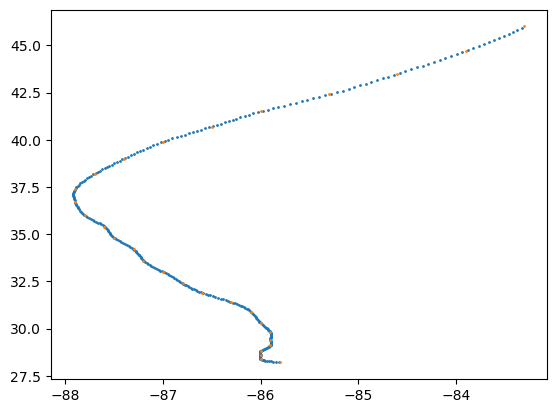

In [26]:
plt.plot(goes_df.LON, goes_df.LAT, 'o', markersize=1)
plt.plot(longitudes, latitudes, 'o', markersize=1)